In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from batch_norm_vgg import VGG, make_layers, make_layers_BN
from batch_norm_callbacks import GradVariation, LossVariation
import matplotlib.pyplot as plt
from operator import add, neg

In [2]:
data_path = untar_data(URLs.CIFAR)

In [3]:
data_path.ls()

[PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/test'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/train'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/labels.txt'),
 PosixPath('/data/students_home/fmameli/.fastai/data/cifar10/models')]

In [4]:
data = ImageDataBunch.from_folder(
                data_path, valid='test', size=32, bs=128)
#             ).split_by_idxs(
#                 train_idx=[0, 1, 2, 3, 4, 5, 5000, 5001, 5002,5003,5004,5005], valid_idx=[0, 1, 2, 3, 4, 5, 1000,1001, 1002,1003,1004,1005]
#             ).label_from_folder(
#             ).databunch(bs=2, num_workers=1, no_check=True)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD

learn_rate = 0.01

In [6]:
# Debug hook

# def print_input(self, input, output):
#     print(self.running_mean)

# convHook = callbacks.Hook(vgg.features[9], print_input, detach=False)

In [7]:
vgg = VGG(make_layers(batch_norm=False), num_classes=data.c).cuda()

learn_vgg = Learner(data, vgg, opt_func=optimizer,
                               loss_func=criterion,
                               true_wd=False,
                               wd=0.,
                               bn_wd=False,
                               metrics=accuracy)

lossVar_noBN = LossVariation(learn_vgg)
gradVar_noBN = GradVariation(learn_vgg)

learn_vgg.fit(10, lr=learn_rate, callbacks=[lossVar_noBN, gradVar_noBN])

epoch,train_loss,valid_loss,accuracy,time
0,2.299606,2.298053,0.127200,00:34
1,2.274589,2.253550,0.220800,00:32
2,2.114209,2.046439,0.253100,00:34
3,2.015588,2.021557,0.246700,00:34
4,1.940504,1.886250,0.308700,01:52
5,1.814139,1.873222,0.315900,01:27
6,1.724644,1.655317,0.396400,01:14
7,1.618658,1.536493,0.431200,00:37
8,1.561898,1.534302,0.438800,00:35
9,1.484616,1.510840,0.445300,00:35


In [8]:
vgg = VGG(make_layers(batch_norm=True), num_classes=data.c).cuda()

learn_vgg = Learner(data, vgg, opt_func=optimizer,
                               loss_func=criterion,
                               true_wd=False,
                               wd=0.,
                               bn_wd=False,
                               metrics=accuracy)

lossVar_BN = LossVariation(learn_vgg)
gradVar_BN = GradVariation(learn_vgg)

learn_vgg.fit(10, lr=learn_rate, callbacks=[lossVar_BN, gradVar_BN])

epoch,train_loss,valid_loss,accuracy,time
0,1.590320,1.932804,0.349600,00:34
1,1.338754,1.274169,0.530400,00:34
2,1.174229,1.829502,0.392300,00:35
3,1.038407,1.034259,0.628300,00:34
4,0.937272,1.005248,0.647500,00:34
5,0.864453,0.878853,0.696600,00:34
6,0.763116,1.281656,0.587500,00:34
7,0.701024,1.147740,0.624200,00:52
8,0.617387,1.052670,0.672100,01:03
9,0.587232,0.818418,0.723900,00:56


# Grads correlation

In [9]:
# All positive example
oldGrads = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
newGrads = torch.tensor([[2,2,2],[3,3,3], [1,2,1]], dtype=torch.float)
oldGrads+newGrads

tensor([[ 3.,  4.,  5.],
        [ 7.,  8.,  9.],
        [ 8., 10., 10.]])

In [10]:
(oldGrads+newGrads).norm(2)

tensor(22.5389)

In [11]:
# one new grad change direction
oldGrads = torch.tensor([[1,2,3],[4,5,6], [7,8,9]], dtype=torch.float)
newGrads = torch.tensor([[-2,-2,-2],[3,3,3], [1,2,1]], dtype=torch.float)
oldGrads+newGrads

tensor([[-1.,  0.,  1.],
        [ 7.,  8.,  9.],
        [ 8., 10., 10.]])

In [12]:
(oldGrads+newGrads).norm(2)

tensor(21.4476)

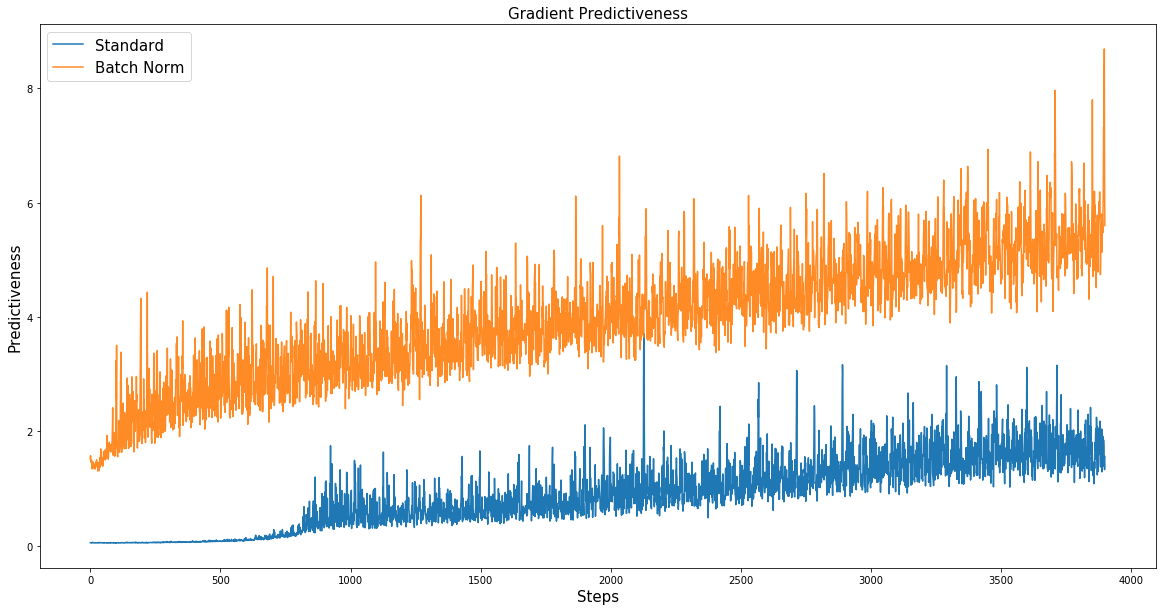

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.ylabel("Predictiveness", fontsize=15)
plt.xlabel("Steps", fontsize=15)
plt.title("Gradient Predictiveness", fontsize=15)

plt.plot(gradVar_noBN.grads_l2, label="Standard")
plt.plot(gradVar_BN.grads_l2, label="Batch Norm",alpha=.9)

ax.legend(fontsize=15)

plt.savefig('grad.png')

In [14]:
from scipy.stats import entropy
import numpy as np

In [15]:
noBN_y = list(map(add,lossVar_noBN.losses, lossVar_noBN.loss_var[10:]))
noBN_x = list(range(len(lossVar_noBN.losses)))

In [16]:
BN_y = list(map(add,lossVar_BN.losses[10:], lossVar_BN.loss_var[10:]))
BN_x = list(range(len(lossVar_BN.losses[10:])))

In [17]:
np.var(lossVar_noBN.losses)

0.07970888

In [18]:
np.var(lossVar_BN.losses)

0.15950224

In [19]:
entropy(lossVar_noBN.losses, base=2)

11.91340470447279

In [20]:
entropy(lossVar_BN.losses, base=2)

11.822513937283606

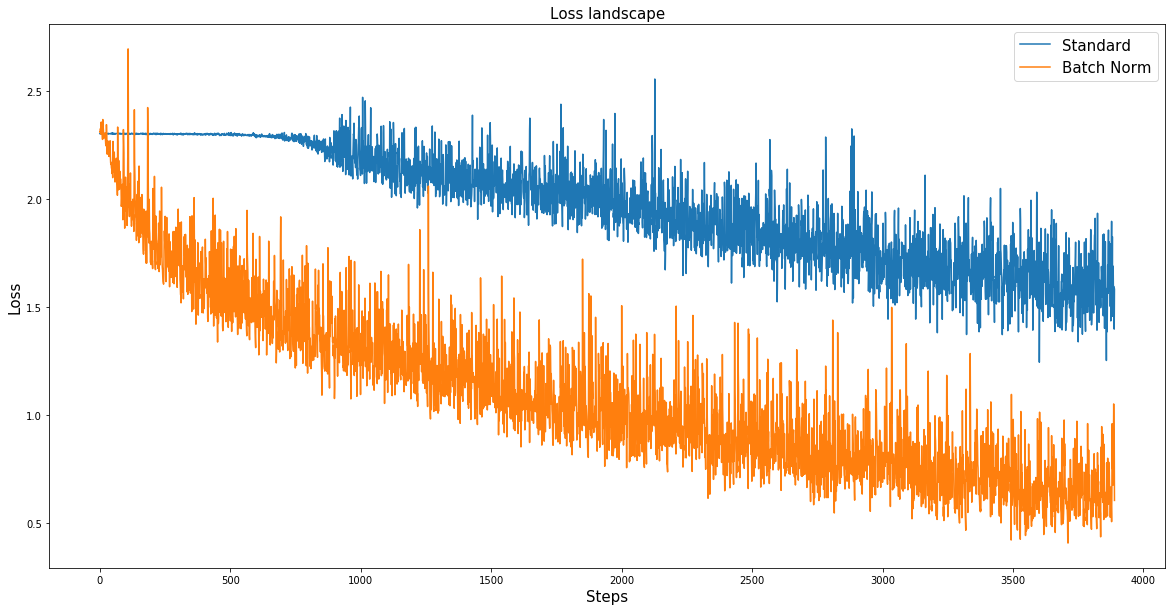

In [21]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Steps", fontsize=15)
plt.title("Loss landscape", fontsize=15)

plt.plot(noBN_y, label="Standard")
# ax.fill_between(noBN_x, noBN_y1, noBN_y2, color="skyblue")
# plt.plot(noBN_y2, label="Standard", color="Blue", linewidth=0.3)

plt.plot(BN_y, label="Batch Norm")

ax.legend(fontsize=15)

plt.savefig('loss.png')